In [127]:
import cartpole_lab.charts
reload(cartpole_lab.charts)

import numpy as np
import gym
from cartpole_lab.progress import log_progress
from cartpole_lab.charts import plot_episode_lengths
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

In [2]:
env = gym.make('CartPole-v1')
observation = env.reset()

In [4]:
from keras.models import Sequential
from keras.layers import Dense # Dropout, BatchNormalization
from keras.optimizers import Adam

class Approximator:
    """A function approximator implemented with a deep neural net."""
    def __init__(self, num_inputs, num_outputs, learning_rate=0.01):
        self.model = Sequential()
        self.model.add(Dense(64, input_shape=(num_inputs,), activation='relu'))
        #self.model.add(Dense(64, activation='relu'))
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dense(num_outputs, activation='linear'))

        adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
        self.model.compile(optimizer=adam, loss='mse', metrics=['accuracy','mse'])

    def predict_multi(self, X_batch):
        """Predict the outputs for multiple input values at once.
        X_batch: an np array of m number of X values to predict, of shape (num_inputs, m)
        where m is the number of items you'd like to predict.
        """
        return self.model.predict(X_batch)
    
    def train_multi(self, X, Y, batch_size=16, epochs=1, verbose=0):
        """
        Train the model with m samples.
        X: the input values, of shape (num_inputs, m)
        Y: the target values, of shape (num_outputs, m)
        """
        return self.model.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    def predict(self, X):
        """Predict a single output given a single input.
        X: one set of X values to predict. X shape is (num_inputs,).
        """
        predictions = self.predict_multi(np.array([X])) # An array for m input values.
        return predictions[0] # We have a batch size of one here; return the first.
    
    def train(self, X, Y):
        """Train a single input/output pair.
        X: inputs of shape (num_inputs,)
        Y: target outputs of shape (num_outputs,)"""
        batch_X = np.array([X])
        batch_Y = np.array([Y])
        self.train_multi(batch_X, batch_Y, batch_size=1)

Using TensorFlow backend.


In [5]:
ap = Approximator(num_inputs=4, num_outputs=2)
X = np.array([[1,2,3,4], [1,1,1,1]])
ap.predict_multi(X)

array([[-1.1119974 , -0.05809563],
       [-0.39100268, -0.07362276]], dtype=float32)

Now train the output for 1234 to be closer to -4,5:

In [6]:
ap.train(np.array([1,2,3,4]), np.array([-4, 5]))

In [7]:
ap.predict(np.array([1,2,3,4]))

array([-2.0003226,  1.2073814], dtype=float32)

In [129]:
class Agent:
    def __init__(self, env, policy):
        self.env = env
        self.policy = policy
    
    def run_episode(self, render=False):
        episode = [] # prev_state, prev_action, reward, state, done
        state = env.reset()
        action = None
        while True:
            prev_state = state
            prev_action = action
            action = self.policy.suggest_action(state)
            state, reward, done, _ = env.step(action)
            episode.append((prev_state, prev_action, reward, state, done))
            self.policy.step_completed(prev_state, prev_action, reward, state, done)
            if render:
                self.env.render()
            if done:
                break
        return episode
    
    def train(self, episodes=100, render=False, epsilon_start=1.0, epsilon_min = 0.01, epsilon_decay=0.995):
        episode_lengths = []
        epsilons = []
        save_image_every = 20
        
        epsilon_orig = agent.policy.epsilon # Save the original epsilon, in case we want to do external things with agent later.
        agent.policy.epsilon = epsilon_start
        
        chartfile = r'images/progress.png'
        for i in log_progress(range(episodes), name='Episodes'):
            episode = self.run_episode(render=render)
            episode_lengths.append(len(episode))
            epsilons.append(agent.policy.epsilon)
            agent.policy.episode_completed(episode)
            if i>0 and i % save_image_every == 0:
                print('saving')
                plot_episode_lengths(episode_lengths, epsilons, save=chartfile)
            
        plot_episode_lengths(episode_lengths, epsilons, save=chartfile)
        print('Max length=%f avg=%f' % (np.max(episode_lengths), np.mean(episode_lengths)))
        
        agent.policy.epsilon = epsilon_orig # Restore epsilon.

In [122]:
from collections import deque
import random

class QLearningPolicy:            
    def __init__(self, env, learning_rate=0.001, epsilon_start=1, epsilon_min=0.01, epsilon_decay=0.995,
                 gamma=0.95, snapshots=1000000, batch_size=20):
        """epsilon: probability of exploring by selecting a random action
        gamma: Discount factor for future rewards. Between 0 - 1.
        learning_rate: learning rate for the approximator
        """
        self.env = env
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma # Discount factor for future rewards.
        self.snapshots = deque(maxlen=snapshots) # [(prev_state, prev_action, reward, next_state, done)]
        num_inputs = self.env.observation_space.shape[0] # 4
        num_outputs = self.env.action_space.n # 2
        self.model = Approximator(num_inputs, num_outputs, learning_rate)
        self.batch_size = batch_size

    def suggest_action(self, state, epsilon=None):
        if epsilon == None:
            epsilon = self.epsilon
        if np.random.uniform() <= epsilon:
            return self.env.action_space.sample()

        rewards_all = self.model.predict(state) # Rewards for all possible actions
        action = np.argmax(rewards_all) # Index of the action having the highest rewards.
        return action

    def step_completed(self, prev_state, prev_action, reward, state, done):
        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        
        # Save this activity for experience replay.
        self.snapshots.append((prev_state, prev_action, reward, state, done))
        
        if len(self.snapshots) >= self.batch_size:
            # Replay a batch of experiences.  This shuffles them so we don't train on a bunch of similar
            # states all at once (temporal separation).
            steps = random.sample(self.snapshots, self.batch_size)
            for (prev_state, prev_action, reward, state, done) in steps:
                rewards_all = self.model.predict(prev_state)
                if done:
                    future_rewards = -1
                else:
                    future_rewards = np.max(self.model.predict(state))
                target_reward = reward + self.gamma * future_rewards
                rewards_all[prev_action] = target_reward
                self.model.train(prev_state, rewards_all)
    
    def episode_completed(self, episode):
        pass


<Figure size 432x288 with 0 Axes>

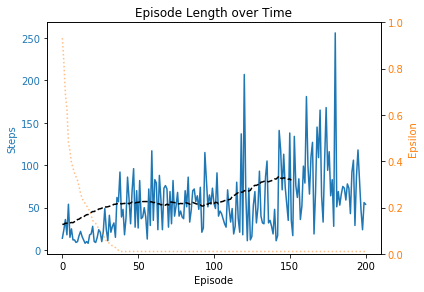

In [ ]:
agent = Agent(env, QLearningPolicy(env))
agent.train(episodes=2000)

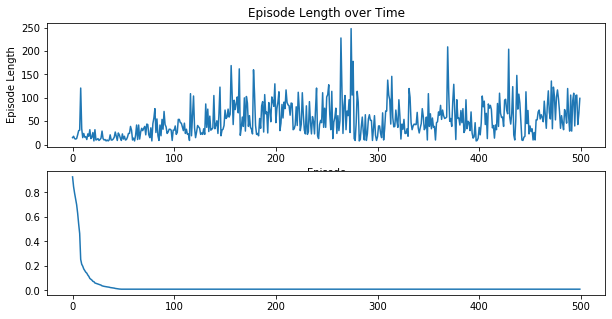

Max length=248.000000 avg=52.390000


In [16]:
agent = Agent(env, QLearningPolicy(env))
agent.train(episodes=500)

In [14]:
def peek():
    state = env.reset()
    return agent.policy.model.predict(state)
peek()

array([20.066944, 20.109468], dtype=float32)

In [33]:
episode_lengths = [9, 19, 17, 24, 32, 54, 76, 12, 92]
epsilons = [0.99 ** i for i in range(len(episode_lengths))]
epsilons

[1.0,
 0.99,
 0.9801,
 0.970299,
 0.96059601,
 0.9509900498999999,
 0.941480149401,
 0.9320653479069899,
 0.9227446944279201]

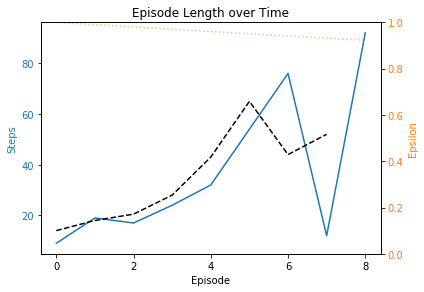

In [94]:
import cartpole_lab.charts
from importlib import reload
reload(cartpole_lab.charts)

from cartpole_lab.charts import plot_episode_lengths, moving_average
plot_episode_lengths(episode_lengths, epsilons)

In [39]:
np.random.random((5,))

array([0.13960762, 0.25780095, 0.58666314, 0.49737478, 0.80376742])

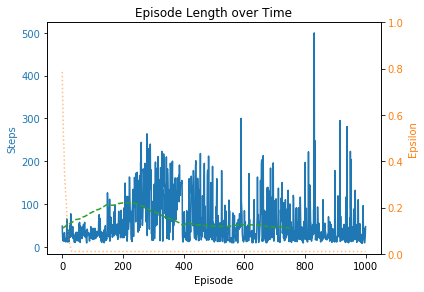

Max length=500.000000 avg=58.515000


In [90]:
agent = Agent(env, QLearningPolicy(env))
agent.train(episodes=1000)

In [95]:
peek()

array([18.590614, 18.793608], dtype=float32)

In [113]:
for i in range(10):
    agent.run_episode(render=True)

In [111]:
env.close()